# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from matplotlib import pyplot as plt
import torchvision
import torch
from torchvision.transforms import ToTensor
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset,random_split,ConcatDataset,WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau, OneCycleLR
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize, MultiLabelBinarizer
import numpy as np
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
import random
import tqdme


device = ("cuda"  if torch.cuda.is_available()  else "mps"  if torch.backends.mps.is_available() else "cpu")

c:\Users\liene\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'seaborn'

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [ ]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

print(test_df["seg"][0].shape)
print(test_df["seg"][0])

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)





## 1.4 Showing the dataset in Pytorch

In [ ]:
# Original dataset from torchvision (I exposed all the parameters )

download = True # please set to true if an error occurs

dowload_folder = './kaggle/temp/'

# Segmentation dataset
pvocS_train = torchvision.datasets.VOCSegmentation(root = dowload_folder, 
                                             year = '2009', 
                                             image_set  = 'train', 
                                             download = download, 
                                             transform = None, 
                                             target_transform = None, 
                                             transforms = None)
pvocS_val = torchvision.datasets.VOCSegmentation(root = dowload_folder, 
                                             year = '2009', 
                                             image_set  = 'val', 
                                             download = download, 
                                             transform = None, 
                                             target_transform = None, 
                                             transforms = None)

# Detection dataset
pvocD_train = torchvision.datasets.VOCDetection(root = dowload_folder, 
                                             year = '2009', 
                                             image_set  = 'train', 
                                             download = download, 
                                             transform = None, 
                                             target_transform = None, 
                                             transforms = None)

pvocD_val = torchvision.datasets.VOCDetection(root = dowload_folder, 
                                             year = '2009', 
                                             image_set  = 'val', 
                                             download = download, 
                                             transform = None, 
                                             target_transform = None, 
                                             transforms = None)

itemtoget = 0 # index of the example item you want to show

# Plot the first item on each dataset to see if it works 
# Note: __getitem__() returns the image and the label in a tuple (image, label)

fig, axs = plt.subplots(1, 6, figsize=(10 * 20, 10 * 2))

axs[0].imshow(pvocS_train.__getitem__(itemtoget)[0])
axs[1].imshow(pvocS_val.__getitem__(itemtoget)[0])
axs[2].imshow(pvocS_train.__getitem__(itemtoget)[1])
axs[3].imshow(pvocS_val.__getitem__(itemtoget)[1])

axs[4].imshow(pvocD_train.__getitem__(itemtoget)[0])
axs[5].imshow(pvocD_val.__getitem__(itemtoget)[0])

for i in range(4):
    axs[i].axis("off")

plt.show()


# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

In [ ]:
class RandomClassificationModel:
    """
    Random classification model: 
        - generates random labels for the inputs based on the class distribution observed during training
        - assumes an input can have multiple labels
    """
    def fit(self, X, y):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        self.distribution = np.mean(y, axis=0)
        print("Setting class distribution to:\n{}".format("\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        y_pred: list of arrays - n x (nb_classes)
        """
        np.random.seed(0)
        return [np.array([int(np.random.rand() < p) for p in self.distribution]) for _ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
#model = RandomClassificationModel()
#model.fit(train_df["img"], train_df[labels])
#test_df.loc[:, labels] = model.predict(test_df["img"])
#test_df.head(1)

## 2.2 CNN Classification

### 2.2.1 Loading and Preprocessing the data

#### 2.2.1.1 Load the data

- Read the train dataset CSV file into a pandas DataFrame.
- Extract the labels and image paths from the DataFrame.
- Define the `ImageDataset` class for custom dataset handling.
- Define the data transformations using torchvision transforms.
- Create an instance of the `ImageDataset` for the train dataset.

In [ ]:
# ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transform=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform is not None:
            image = Image.fromarray(image)
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform is not None:
                label = self.transform(label)
            return image, label
        else:
            return image


In [ ]:
# Calculate mean and std
train_dataset_for_stats = ImageDataset(train_df['img'].to_list(), train_df[labels].to_numpy(), transform=ToTensor())
meanRGB = [np.mean(x[0].numpy(), axis=(1, 2)) for x in train_dataset_for_stats]
stdRGB = [np.std(x[0].numpy(), axis=(1, 2)) for x in train_dataset_for_stats]


meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))

In [ ]:
# Train set transforms
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=(0.80, 1.20)),
        transforms.RandomGrayscale(p=0.25)
    ]),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

In [ ]:
# Validation set transforms
val_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((350, 350)),
    transforms.CenterCrop((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

### 2.2.1.2 Class Distribution Histogram

The class distribution histogram indicates that the labels are imbalanced, with the "person" class being on average 4x more frequent than the other classes. As people are often in images with other classes like bicycles and motorbikes. However for the classifier to learn from a fair propotion of each class and to prevent the model from focusing too much on a specific class, the imbalance needs to be adressed.

**Upsampling & Undersampling:**

One solution is to upsample, but since there are only a limited number of instances, this would result in resampling the same instances multiple times, hindering the model's generalization. Alternatively, we could undersample the majority class, however the could lead to removal of images from already underrepresented classes.

**Weighting**

Instead we will attempt to address this imbalance during the learning process. This weighting scheme gives importance to the minority class, while it reduced the dominance of the majority class. The weights are calculated based on the class counts, where the weight of a class is inversely proportional to its occurrence in the dataset. During model training, it was observed that this weighting approach imporved generalization and led to faster performance on the validation set.

In [ ]:
# Initialize the dictionary to store the count of each class
class_count = {label: 0 for label in labels}

# Iterate through the ground truth labels in the dataset
for label in labels:
    class_count[label] = train_df[label].sum()

# Create a dictionary of classes and their numeric index (ordered alphabetically)
class_dictionary = {i: label for i, label in enumerate(sorted(labels))}
class_dictionary_inv = {label: i for i, label in class_dictionary.items()}

# Plot the histogram of the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_dictionary_inv.keys(), class_count.values())
plt.xlabel('Class')
plt.xticks(list(class_dictionary.keys()), list(class_dictionary.values()), rotation=45)
plt.ylabel('Count')
plt.title('Histogram of Class Distribution')
plt.show()

# Calculate the number of labels for each class by summing the values in each column
class_counts = train_df[labels].sum(axis=0)

# Display the vector with the number of labels for each class
print(class_counts)

# Calculate the total number of labels
total_labels = class_counts.sum()

# Display the total number of labels
print(f"Total: {total_labels}")

#### 2.2.1.3 Calculating and Normalizing Class Weights for Imbalanced Labels

In [ ]:
def calculate_weights(class_counts):
    weights = np.ones_like(class_counts)
    total_samples = class_counts.sum()
    neg_counts = [total_samples - pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts, neg_counts)):
        weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(weights, dtype=torch.float)

weights = calculate_weights(class_counts)
weights_tensor = torch.tensor(weights, dtype=torch.float, device=device)

print(weights_tensor)

### 2.2.2 Split the data into train and validation sets and create Dataloader

In [ ]:
# Split the data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create instances of ImageDataset for the train and validation datasets
train_dataset = ImageDataset(train_df['img'].to_list(), train_df[labels].to_numpy(), transform=train_transforms)
val_dataset = ImageDataset(val_df['img'].to_list(), val_df[labels].to_numpy(), transform=val_transforms)

# Create instances of ImageDataset for the test set
test_dataset = ImageDataset(test_df['img'].to_list(), test_df[labels].to_numpy(), transform=test_transforms)

### 2.2.2.1 Perform data augmentation by equally augmenting the samples of each class

In [ ]:
def augment_dataset(dataset, num_augmentations):
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(10,10,10,10)),
        transforms.RandomPerspective(),
    ]

    augmented_datasets = []
    for i in range(num_augmentations):
        transform = transforms.Compose(random.sample(transform_list, k=3))
        augmented_dataset = []
        for data in dataset:
            augmented_data = list(data)
            augmented_data[0] = transform(augmented_data[0])
            augmented_dataset.append(tuple(augmented_data))
        augmented_datasets.append(augmented_dataset)

    # Concatenate the augmented datasets
    concatenated_dataset = []
    for augmented_dataset in augmented_datasets:
        concatenated_dataset += augmented_dataset

    return concatenated_dataset

In [ ]:
augmented_train_set = augment_dataset(train_dataset, num_augmentations=4)

In [ ]:
augmented_train_set = ConcatDataset([train_dataset, augmented_train_set])

### 2.2.2.2 Perform data augmentation by augmenting the samples of all classes except the predominant 'person' class in order to balance the dataset

### Upsampling  approach - Drawbacks

In the context of an imbalanced dataset, there are a few strategies we could consider to address the issue. One approach is upsampling, where we generate synthetic data to increase the representation of the minority class. However, in our case, since the dataset is not large, upsampling could result in duplicating the same instances multiple times. This can be problematic because it may lead to overfitting and hinder the generalization capability of our classifier.

Another approach is undersampling, which involves removing a portion of the majority class to balance the class distribution. However, if we were to apply undersampling to the images containing people, for example, we run the risk of removing images from classes that are already in the minority. This is not an ideal solution for our dataset, as we cannot afford to lose valuable data from these minority classes.

To mitigate the potential issues mentioned earlier and explore the effectiveness of the upsampling approach, we decided to augment our dataset. However, we did that by increasing the number of instances for every class except the "person" class, maintaining a relatively proportional balance.

Despite implementing the dataset augmentation approach, we did not observe an improvement in performance. Therefore, we have decided to keep the former strategy of assigning weights to each class.

In [ ]:
def augment_dataset_except_class(dataset, num_augmentations):
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(10, 10, 10, 10)),
        transforms.RandomPerspective(),
    ]

    augmented_datasets = []
    for i in range(num_augmentations):
        transform = transforms.Compose(random.sample(transform_list, k=3))
        augmented_dataset = []
        for data in dataset:
            if data[1][14] != 1:
                augmented_data = list(data)
                augmented_data[0] = transform(augmented_data[0])
                augmented_dataset.append(tuple(augmented_data))
            else:
                augmented_dataset.append(data)
        augmented_datasets.append(augmented_dataset)

    # Concatenate the augmented datasets
    concatenated_dataset = []
    for augmented_dataset in augmented_datasets:
        concatenated_dataset += augmented_dataset

    return concatenated_dataset

In [ ]:
# augmented_train_set = augment_dataset_except_class(train_dataset, num_augmentations=4)

### 2.2.2.3 Create Dataloader

In [ ]:
# Create DataLoaders for train_dataset and val_dataset
# For the 'trained from scratch' case data augmentation is needed to train the model, due to the lack of sufficient training data
train_loader = DataLoader(augmented_train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Visualize train loader size
len(train_loader)

# Create DataLoader for test_dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

### 2.2.2.4 Visualize some of the generated training images

In [ ]:
def visualize_batch(train_loader, class_names):
    # Get a batch of images and labels from train_loader
    images, batch_labels = next(iter(train_loader))
    
    # Convert images from tensors to numpy arrays
    images = images.numpy()

    # Create a figure 
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(np.transpose(images[i], (1, 2, 0)))

            # Get the class indices where the label is 1
            label_indices = [j for j, val in enumerate(batch_labels[i]) if val == 1]

            # Map class indices to class names
            label_names = [class_names[idx] for idx in label_indices]

            ax.set_title(label_names)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [ ]:
visualize_batch(train_loader, labels)

## 2.2.3.1 Creating CNN Models

In [ ]:
# Define the network architecture
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(180000, 20)  # Update the input size of the fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
class ComplexNetwork(nn.Module):
    def __init__(self):
        super(ComplexNetwork, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(82944, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, 20)
        self.relu6 = nn.ReLU(inplace=True)
#         self.dropout2 = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Flatten the output from convolutional layers before passing to fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu5(x)
#         x = self.dropout1(x)
        x = self.fc2(x)
#         x = self.relu6(x)
#         x = self.dropout2(x)
        

        return x

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()

        self.channel_dim = 1 if torch.cuda.is_available() else -1

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.dropout1 = nn.Dropout2d(p=0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(80000, 1024)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 20)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.bn6(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [ ]:
def get_alexnet_model(input_shape, nb_classes):
    model = models.alexnet(weights=None)
    # Replace the last fully connected layer with a new one
    model.classifier[6] = nn.Linear(4096, nb_classes)
    # Modify the input layer to accept the desired input shape
    model.features[0] = nn.Conv2d(input_shape[0], 64, kernel_size=11, stride=4, padding=2)
    return model

In [ ]:
def build_resnet():
    model = models.resnet34(weights=None, num_classes=20)
    model = model.to(device)
    return model

### Initialize the model, define the loss function, the optimizer, the scheduler, and train the model.

In [ ]:
# # Initialize the model, loss function, and optimizer
# model = SimpleNetwork().to(device)
model = ComplexNetwork().to(device)
# model = TinyVGG().to(device)

# input_shape = (3, 300, 300)
# nb_classes = 20
# model = get_alexnet_model(input_shape, nb_classes).to(device)
# model = build_resnet()

criterion = nn.BCEWithLogitsLoss(weight=weights_tensor)

optimizer = optim.SGD(model.parameters(), lr=0.00015, momentum=0.9)

# Define the scheduler
max_lr = 0.01  # Maximum learning rate
num_epochs = 2
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr, steps_per_epoch, epochs = num_epochs)

### 1cycle learning
The 1cycle learning rate policy changes the learning rate after every batch. It was chosen as the preferable scheduler since it offers faster convergence, improved generalization, reduced overfitting, robustness to hyperparameter tuning, and flexibility in training neural networks. 

In [ ]:
print(model)

### Description of ComplexNetwork architecture (best performing custom architecture):

* The **architecture** consists of four sets of convolutional layers followed by batch normalization, ReLU activation, and max pooling operations.
* The **convolutional layers** have kernel sizes of 3x3, stride 1, and padding 1 to maintain the spatial dimensions.
* The number of output channels progressively increases from 32 to 256, indicating increasing complexity and abstraction of features.
* After each convolutional layer, **batch normalization** is applied to normalize the activations and improve network stability.
* **ReLU activation** functions introduce non-linearity to the network, allowing it to learn complex representations.
* **Max pooling** with a kernel size of 2x2 and stride 2 is used to downsample the spatial dimensions, reducing computational complexity and capturing more prominent features.
* After the convolutional layers, the output is flattened to a 1D vector before being fed into the fully connected layers.
* The architecture has two **fully connected layers** with 512 and 20 units, respectively.
* ReLU activation functions are used after each fully connected layer to introduce non-linearity.
* The final output is obtained from the second fully connected layer.


### Things we tried to improve performance that did not work out:
* A dropout layer with a dropout probability of 0.5 was applied after the first fully connected layer to mitigate overfitting.

1. Dropout is primarily beneficial for regularizing and preventing overfitting in neural networks. However, in the case of imbalanced datasets, like ours, where certain classes have significantly fewer samples than others, dropout may further reduce the already limited representation of minority classes.
1. Dropout randomly sets a fraction of the input units to zero during training, which helps in reducing interdependent learning among neurons. However, when the dataset is imbalanced, dropping out units may result in the loss of important information specific to minority classes.
1. Dropout acts as a regularization technique by introducing noise and forcing the network to learn redundant representations. This may reduce the model's capacity to learn complex patterns present in the minority classes.

### ResNet-34 Vs ComplexNetwork

ResNet-34 is a powerful and deep architecture known for its skip connections and excellent performance on image classification tasks. It is suitable for complex datasets and situations where high accuracy is desired. On the other hand, ComplexNetwork is a simpler and computationally lighter alternative that still performed reasonably well on our image classification tasks while using limited computational resources. The choice between the two models was arbitrary, since both the ResNet-34 and the CompleNetwork were evaluated for the image classification task on our small dataset, and their performance was found to be similar on average. Therefore, we will demonstrate the performance of **ComplexNetwork**. In addition the ResNet-34 was specifically trained on the small dataset at hand, with all its weights determined through the training process. Finally, the improved performance of ResNet-34 when utilizing pre-trained weights, will be demonstrated later.

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_train_preds = []
    epoch_train_true = []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        predicted_labels = (torch.sigmoid(outputs) >= 0.5).float()
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0) * len(labels)

        
        epoch_train_preds.extend(predicted_labels.detach().cpu().numpy())
        epoch_train_true.extend(labels.detach().cpu().numpy())

    train_loss /= len(dataloader.dataset)
#     train_acc = train_correct / train_total
    train_acc = accuracy_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
    train_precision = precision_score(epoch_train_true, epoch_train_preds, average='weighted', zero_division=1)
#     train_precision = precision_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1), zero_division = 1)
    train_recall = recall_score(epoch_train_true, epoch_train_preds, average='weighted', zero_division=1)
#     train_recall = recall_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
    train_f1 = f1_score(epoch_train_true, epoch_train_preds, average='weighted', zero_division=1)
#     train_f1 = f1_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))

    return train_loss, train_acc, train_precision, train_recall, train_f1

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    epoch_val_preds = []
    epoch_val_true = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float())

            val_loss += loss.item() * images.size(0)

            predicted_labels = (torch.sigmoid(outputs) >= 0.5).float()
            val_correct += (predicted_labels == labels).sum().item()
            val_total += labels.size(0) * len(labels)

            epoch_val_preds.extend(predicted_labels.detach().cpu().numpy())
            epoch_val_true.extend(labels.detach().cpu().numpy())

    val_loss /= len(dataloader.dataset)
#     val_acc = val_correct / val_total
    val_acc = accuracy_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
    val_precision = precision_score(epoch_val_true, epoch_val_preds, average='weighted', zero_division=1)
#     val_precision = precision_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1), zero_division=1)
    val_recall = recall_score(epoch_val_true, epoch_val_preds, average='weighted', zero_division=1)
#     val_recall = recall_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
    val_f1 = f1_score(epoch_val_true, epoch_val_preds, average='weighted', zero_division=1)
#     val_f1 = f1_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))

    return val_loss, val_acc, val_precision, val_recall, val_f1


In [ ]:
# Add lists to store training and validation losses and metrics
train_losses, val_losses = [], []
train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], []
val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], []
patience = 5

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    
    # Update the learning rate using the scheduler
    scheduler.step()
    
    # Validation
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    # Early stopping
    if len(val_losses) > patience:
        last_losses = val_losses[-patience:]
        if all(last_losses[i] <= last_losses[i+1] for i in range(patience-1)):
            print("Validation loss did not improve for {} consecutive epochs. Early stopping...".format(patience))
            break
    
    print(f"Epoch {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    print(f"train_acc {train_acc: .4f} | val_acc: {val_acc: .4f}")
    print(f"train_precision: {train_precision:.4f} | val_precision: {val_precision:.4f}")
    print(f"train_recall: {train_recall:.4f} | val_recall: {val_recall:.4f}")
    print(f"train_f1_score: {train_f1:.4f} | val_f1_score: {val_f1:.4f}")
    print('------------------------------------')

In [ ]:
# Evaluate performance of a random batch
batch_images, batch_labels = next(iter(val_loader))

batch_preds = model(batch_images.to(device))
batch_preds = (torch.sigmoid(batch_preds.to(device)) >= 0.5).float()

# Update the 'labels' list to include the correct subset of classes
evaluated_classes = [labels[i] for i in range(len(labels)) if i in torch.unique(torch.argmax(batch_labels, dim=1))]
true_labels_subset = [labels[i] for i in torch.argmax(batch_labels, dim=1).cpu().numpy()]  # Convert class indices to class names
predicted_labels_subset = [labels[i] for i in torch.argmax(batch_preds, dim=1).cpu().numpy()]  # Convert class indices to class names
# print(true_labels_subset)
print(predicted_labels_subset)
# Compute confusion matrix
cm = confusion_matrix(true_labels_subset, predicted_labels_subset, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Compute and print classification report
report = classification_report(true_labels_subset, predicted_labels_subset, zero_division=1)#, target_names=evaluated_classes, )
print(report)

### Early stopping
In the provided implementation, the early stopping mechanism is implemented using a patience value, which is set to 5. After each epoch, the validation loss is computed. If the number of validation losses recorded is greater than the patience value, the last patience number of losses are extracted and then we check whether the last patience losses are less than or equal to the subsequent loss. This way we examine if the validation loss did not improve for patience consecutive epochs. If this condition is satisfied, it means that the model's performance is not improving, and the training process is stopped by breaking out of the training loop. This implementation of early stopping ensures that the training process is terminated when there is no significant improvement in the validation loss over a specified number of epochs. By stopping the training early, it helps prevent overfitting and saves computational resources.

In [ ]:
# Plot images alongside corresponding model predictions
def plot_batch(batch_images, batch_labels, labels, model):
    batch_preds = model(batch_images)
    batch_preds = (torch.sigmoid(batch_preds) >= 0.5).float()

    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
    fig.tight_layout()

    for idx, (image, label, pred) in enumerate(zip(batch_images.cpu(), batch_labels, batch_preds)):
        row = idx // 4
        col = idx % 4

        image = image.permute(1, 2, 0).clamp(0, 1)
        axes[row, col].imshow(image)

        true_labels = [labels[i] for i, val in enumerate(label) if val == 1.0]
        pred_labels = [labels[i] for i, val in enumerate(pred) if val == 1.0]

        axes[row, col].set_title(f"True Labels: {true_labels}\nPredicted Labels: {pred_labels}")
        axes[row, col].axis('off')

    plt.show()

In [ ]:
batch_images, batch_labels = next(iter(val_loader))
plot_batch(batch_images.to(device), batch_labels.to(device), labels, model)

### Evaluate - Interpret visualisations

* Good Cases:

**Distinctive objects**: Objects such as 'aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'motorbike', 'person', 'train', and 'tvmonitor' have distinct visual features that make them relatively easier to classify correctly. These objects are likely to have well-defined shapes and unique characteristics that can be captured by the model, leading to accurate predictions.

**Sufficient representation**: Having a sufficient number of examples for each class ensures that the model can learn the specific patterns and features associated with each object, reducing the chances of misclassification. It is obvious that in our case only the predominant **'person'** class is most of the times correctly classified. 

* Bad Cases:

**Imbalanced dataset**: The dataset is highly imbalanced, meaning some classes have significantly more samples than others, the model may struggle to perform well on the minority classes. Objects such as **'bottle'**, **'cow'**, **'sheep'**, **'bicycle'**, **'train'**, and **'bus'** have fewer examples, leading to reduced exposure and lower accuracy for these classes.

* Potential Mistakes:

**Confusion between similar classes**: Objects that share visual similarities, such as **'car'** and **'bus'**, **'sheep'** and **'cow'**, or **'chair'** and **'sofa'**, can be a source of confusion for the model. The model may struggle to differentiate between these objects, leading to misclassifications, especially when the dataset does not provide sufficient discriminative features or examples for these classes.

### Plotting the metrics

In [ ]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_precision(train_precisions, val_precisions):
    epochs = range(1, len(train_precisions) + 1)
    plt.plot(epochs, train_precisions, label='Training Precision')
    plt.plot(epochs, val_precisions, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.show()

In [ ]:
def plot_recall(train_recalls, val_recalls):
    epochs = range(1, len(train_recalls) + 1)
    plt.plot(epochs, train_recalls, label='Training Recall')
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.show()

In [ ]:
def plot_f1_score(train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_f1_scores) + 1)
    plt.plot(epochs, train_f1_scores, label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    plt.show()

In [ ]:
# Plot the metrics
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)
plot_precision(train_precisions, val_precisions)
plot_recall(train_recalls, val_recalls)
plot_f1_score(train_f1s, val_f1s)

### ComplexNetwork - Discussion

**Loss**: The training loss decreases consistently from epoch to epoch, indicating that the model is learning and improving its predictions. However, the validation loss fluctuates and does not show a clear decreasing trend, which suggests that the model might be overfitting the training data.

**Accuracy**: The training accuracy starts at 0.9167 in the first epoch and gradually increases to 0.9296 in the final epoch. The validation accuracy also improves but fluctuates around 0.9187, indicating that the model generalizes moderately well to unseen data.

**Precision**: The training precision starts at 0.1164 and increases to 0.7508 in the last epoch. The validation precision also improves but fluctuates between 0.6519 and 0.9655, indicating some inconsistency in the model's ability to correctly predict positive samples.

**Recall**: The training recall starts at 0.0335 and increases to 0.1048 in the final epoch, while the validation recall shows a similar trend but with lower values, ranging from 0.0069 to 0.1172. This suggests that the model struggles to capture all positive instances, especially in the validation set.

**F1-Score**: The training F1-score starts at 0.0501 and increases to 0.1669 in the last epoch. The validation F1-score also improves but with values ranging from 0.0110 to 0.1568, indicating that the model has room for improvement in terms of finding the right balance between precision and recall.

### TinyVGG Implementation - Discussion

**Loss**: The training loss decreases consistently from epoch to epoch, indicating that the model is learning and improving its predictions. However, the validation loss fluctuates and does not show a clear decreasing trend, which suggests that the model might be overfitting the training data.

**Accuracy**: The training accuracy starts at 0.3822 in the first epoch and gradually increases to 0.6005 in the final epoch. The validation accuracy also improves but fluctuates around 0.6, indicating that the model generalizes moderately well to unseen data.

**Precision**: The training precision starts at 0.1129 and increases to 0.7892 in the last epoch. The validation precision also improves but fluctuates between 0.3037 and 1.0, indicating some inconsistency in the model's ability to correctly predict positive samples.

**Recall**: The training recall starts at 0.4242 and increases to 0.5499 in the final epoch, while the validation recall shows a similar trend but with lower values, ranging from 0.0 to 0.0183. This suggests that the model struggles to capture all positive instances, especially in the validation set.

**F1-Score**: The training F1-score starts at 0.1660 and increases to 0.6461 in the last epoch. The validation F1-score also improves but with values ranging from 0.0 to 0.0337, indicating that the model has room for improvement in terms of finding the right balance between precision and recall.

### SimpleNetwork - Discussion

**Loss**: The training loss gradually decreases over the epochs, indicating that the model is learning and improving its ability to minimize the difference between predicted and actual values. However, the validation loss initially decreases but then starts to increase again after a few epochs, suggesting that the model may be overfitting to the training data.

**Accuracy**: Both the training and validation accuracies hover around 0.60, indicating that the model performs similarly on both the training and validation sets. However, the accuracy does not improve significantly over the epochs, suggesting that the model may have reached a performance limit.

**Precision**: The precision values for both training and validation sets are relatively high, especially for the validation set. This indicates that when the model predicts a positive result, it is often correct, particularly for the validation data. The precision values improve over the epochs, suggesting that the model becomes better at minimizing false positives.

**Recall**: The recall values are relatively low for both training and validation sets, indicating that the model has a tendency to miss true positive results. The recall values remain relatively stable and do not show significant improvement over the epochs.

**F1 Score**: The F1 scores follow a similar pattern to the recall values. They are relatively low and do not show substantial improvement over the epochs. This suggests that the model struggles to balance precision and recall effectively.

### Overall discussion

Training a model from scratch on a small, imbalanced dataset with 20 classes is challenging for several reasons, which can lead to poor performance despite taking various measures to improve it. Here are some reasons why such a scenario is generally expected to result in suboptimal performance:

* **Limited Data**: With a small dataset, the model has limited examples to learn from, making it difficult to capture the complexity and variability of the 20 classes adequately. Deep learning models typically require a large amount of diverse data to generalize well.

* **Class Imbalance**: Imbalanced datasets pose a significant challenge as the model may become biased towards the majority classes, often at the expense of the minority classes. Despite assigning weights to each class, which can help address the imbalance to some extent, the scarcity of samples from minority classes can still block the model's ability to learn and generalize effectively.

* **Complexity of the Problem**: Handling a classification problem with 20 classes is inherently more complex than binary or few-class classification. Each additional class introduces more variations, making it harder for the model to discriminate between them accurately.

* **Model Capacity and Architecture**: Both shallow and deep CNN architectures have their limitations. Shallow architectures (SimpleNetwork, ComplexNetwork, TinyVGG) may lack the capacity to capture complex patterns and relationships in the data, while deep architectures (AlexNet, ResNet-34) might struggle with overfitting due to limited training data. Augmentation techniques can help increase the effective size of the dataset, but they cannot fully compensate for the inherent limitations of a small dataset.

* **Adaptive Learning Rate and Scheduler**: Using adaptive learning rate techniques and schedulers can help in stabilizing and optimizing the learning process. However, while they can improve training dynamics and convergence, they might not be sufficient to overcome the challenges posed by the small, imbalanced dataset alone, **as it is evident in our case**.

## 2.2.3 Loading Pre-trained ResNet50 Model

In [ ]:
# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the classifier
num_features = model.fc.in_features
num_classes = 20
model.fc = torch.nn.Linear(num_features, num_classes)

### 2.2.4 Set up the model and Optimizer
- Load the pre-trained VGG model and replace the last layer for classification.
- Move the model to the device.
- Set up the loss function and optimizer.

### Motivation for Loss function and optimizer

**Loss function:**

The `BCEWithLogitsLoss` (Binary Cross-Entropy with Logits Loss) is often used in multi-label classification problems, where each input can belong to multiple classes and each label is independent of each other. The loss function combines the binary cross-entropy loss and the sigmoid activation function in a single class. This provides high numerical stability. The equation for Binary Cross-Entropy is given as:

\begin{equation}
L(y, t)=-\left(t^* \log (y)+(1-t) * \log (1-y)\right)
\end{equation}

with L(y,t) the loss, y the predicted probability and t the true label (0 or 1). y is obtained by applying the sigmoid function to the output logit from the model.

The `weight` parameter allows to specify a weight tensor. This weight tensor assigns different weights to each class individually in multilabel classification problems. It allows to handle class imbalance by assigning higher weights to underrepresented classes and lower weights to overrepresented classes.

In [ ]:
# Move the model to the device (GPU if available)
model = model.to(device)
model.eval()

# Set up the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss(weight=weights_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 2.2.5 Training loop
- Define lists to store training and validation metrics.
- Iterate over epochs.
- Set the model in training mode.
- Iterate over batches in the train DataLoader.
- Move inputs and targets to the device.
- Zero the gradients and perform forward and backward passes.
- Calculate and store training metrics.
- Set the model in evaluation mode.
- Iterate over batches in the validation DataLoader.
- Calculate and store validation metrics.
- Print and store the metrics for each epoch.

### Motivation for Model Evaluation Metrics and Implementation:


Since we are dealing with a multi-label classification problem. The sigmoid function is used. This function converts the model's output logits to probabilties. This allow each class's probability to be independent of each other, allowing for multiple classes to have a high probability.

**Accuracy:**

In determining the appropriateness of accuracy as a metric for our problem, it is essential to understand the definition of accuracy within the context of multi-label classification. Accuracy can be formally defined as:

\begin{equation}
\text { Accuracy }=\frac{\text { True Positives }+ \text { True Negatives }}{\text { True Positives }+ \text { True Negatives }+ \text { False Positives }+ \text { False Negatives }}
\end{equation}

Imagine the following truth and predicted labels:

$y_{true} = [1, 0, 1, 0, 0, 0]$

$y_{pred} = [0, 1, 1, 0, 1, 0]$

In this case we have:
- 1 false negative (1st element)
- 2 false positives (2nd and 5th elements)
- 2 true negatives (4th and 6 th elements)
- 1 true positive (3rd element)

The accuracy is:

\begin{equation}
\text { Accuracy }=\frac{1+2}{1+2+2+1}=\frac{3}{6}=50 \%
\end{equation}

The obtained accuracy is unexpectedly high, given that only 1 out of 6 labels are correctly predicted. In practice, we are dealing with 20 classes, which implies that the predicted array would be significantly larger and likely contain a greater proportion of zeros (as each image is expected to belong to a limited number of classes). 

**F1 Score:**

The F1-score was chosen, because it provides a balanced model's performance assessment, combining both precision and recall. Precision defined as: 

\begin{equation}
\text { Precision }=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}
\end{equation}

focuses on measuring the model's ability to correctly identify positive instances. Whereas recall, defined as:

\begin{equation}
\text { Recall }=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}
\end{equation}

measures the ability of the model to identify all positive instances within the dataset. The F1-score defined as: 

\begin{equation}
F 1-\frac{2 * \text { Precision* Recall }}{\text { Precision }+ \text { Recall }}
\end{equation}

provides a mean of precision and recall, allowing for equal contribution of both metrics in evaluating the model's performance.



In [ ]:
# Set the number of epochs
num_epochs = 2

# Initialize lists to store the training and validation loss values
train_f1_scores = []
val_f1_scores = []
train_avg_precisions = []
val_avg_precisions = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    epoch_train_true = []
    epoch_train_pred = []
    epoch_val_true = []
    epoch_val_pred = []
    model.train()

    # Print the current epoch number
    print(f'Epoch {epoch + 1}/{num_epochs}')

    # Train the model
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the device (GPU if available)
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float().to(device))

        # Store true and predicted labels for F1 score and average precision calculation
        epoch_train_true.extend(targets.cpu().numpy().tolist())
        epoch_train_pred.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validate the model
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Multiply targets by the class_weights_tensor to get weighted_targets
            loss = criterion(outputs, targets.float().to(device))
            running_val_loss += loss.item()

            # Store true and predicted labels for F1 score and average precision calculation
            epoch_val_true.extend(targets.cpu().numpy().tolist())
            epoch_val_pred.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        val_losses.append(running_val_loss / len(val_loader))

    
    # Convert the lists to NumPy arrays
    epoch_train_true = np.array(epoch_train_true)
    epoch_train_pred = np.array(epoch_train_pred)
    epoch_val_true = np.array(epoch_val_true)
    epoch_val_pred = np.array(epoch_val_pred)

    # Apply a threshold to the predicted labels
    threshold = 0.5
    epoch_train_pred = (epoch_train_pred >= threshold).astype(int)
    epoch_val_pred = (epoch_val_pred >= threshold).astype(int)

    n_classes = 20
    train_binarized_true = epoch_train_true
    train_binarized_pred = epoch_train_pred
    val_binarized_true = epoch_val_true
    val_binarized_pred = epoch_val_pred

    train_avg_precision = average_precision_score(train_binarized_true, train_binarized_pred, average='weighted')
    val_avg_precision = average_precision_score(val_binarized_true, val_binarized_pred, average='weighted')

    # Calculate F1 scores and average precision values
    train_f1 = f1_score(epoch_train_true, epoch_train_pred, average='weighted')
    val_f1 = f1_score(epoch_val_true, epoch_val_pred, average='weighted')

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_avg_precisions.append(train_avg_precision)
    val_avg_precisions.append(val_avg_precision)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Train Avg Precision: {train_avg_precision:.4f}, '
          f'Val Avg Precision: {val_avg_precision:.4f}')
    
print('Finished Training')

### 2.2.6 Verification code

In [ ]:
labels = train_df.columns[0:20]

for i, label in enumerate(labels):
    print(f"{i+1}: {label}")

In [ ]:
# Get class names from labels
class_names = list(train_df.columns[0:20])

# Number of samples you want to print
num_samples_to_print = 2

for i in range(len(val_dataset)):
    sample, true_labels = val_dataset[i]
    inputs = sample.unsqueeze(0).to(device)
    true_labels = [class_names[j] for j, val in enumerate(true_labels) if val == 1]

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy().tolist()[0]
        predicted_labels = [class_names[j] for j, val in enumerate(probabilities) if val >= 0.5]

    # Print only the first num_samples_to_print samples
    if i < num_samples_to_print:
        print(f"Sample {i+1}:")
        print(f"True Labels: {true_labels}")
        print(f"Predicted Labels: {predicted_labels}")
        
        for j, prob in enumerate(probabilities):
            class_label = class_names[j]
            print(f"{j+1}: {class_label}: {prob}")

        print()


### 2.2.7 Visualizing Training and Validation Metrics: Loss, F1 Score and Average Precision

In [ ]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the training and validation loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot the training and validation F1 scores
axes[1].plot(train_f1_scores, label='Train F1 Score')
axes[1].plot(val_f1_scores, label='Validation F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()

# Plot the training and validation average precision
axes[2].plot(train_avg_precisions, label='Train Avg Precision')
axes[2].plot(val_avg_precisions, label='Validation Avg Precision')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Average Precision')
axes[2].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


### 2.2.8 Adding the results to the dataframe

In [ ]:
# Get class names from labels
class_names = list(test_df.columns[0:20])
class_vector = np.empty((750,20))
print(class_names)

for i in range(750):

    if i % 100 == 0:
        print(i)
    im = test_dataset.__getitem__(i)[0]
    im = np.expand_dims(im,axis=0)
    im = torch.tensor(im).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(im)
        probabilities = torch.sigmoid(outputs).cpu().numpy().tolist()[0]

    for c in range(len(class_names)):
        class_vector[i,c] = probabilities[c]
    

for c in range(len(class_names)):
    test_df[class_names[c]][:] = class_vector[:,c]


In [ ]:
test_df.head(5)

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

# 3.0 Segmentation oriented CNNs

Given the assignment and the tasks we were called to solve, we reviewed the related literature [1,2] on the issue. Two of the most fundamental deep learning architectures for the task of semantic image segmentation in the last decade are ResNet[3] and U-Net[4]. The latter constitutes one of the earliest forms of DL-based techniques to tackle the subject of image segmentation in the context of biomedicine, while the former constitutes the backbone of the majority of the latest implementations of complex neural networks to tackle the task. 
Given that the resources provided (part of PASCAL VOC 2009) were limited, as well as our training resources, we decided to work with the aforementioned architectures, as they are proven to be efficient, while also providing us the opportunity to explore the basis of the DL-based approach theory on the task. Due to ResNet being more computationally demanding, we chose to use its variant - ResNet50 - in its pretrained form, while implementing from scratch and training U-Net, which was easier to implement from scratch and less computationally demanding to train.

Convolutional Neural Networks for sematic segmentation use an Encoder-Decoder architecture where the encoder is tasked with discriminating pixels while the decoder is tasked with projecting the results into regions. 

References:
- 1: https://doi.org/10.1016/j.asoc.2018.05.018
- 2: https://doi.org/10.1109/TPAMI.2021.3059968
- 3: https://arxiv.org/abs/1512.03385
- 4: https://arxiv.org/abs/1505.04597

## 3.1 Segmentation using UNet

Some notable examples of models used in semantic segmentation are ResNet and UNet. The following section shows a prediction example of the Pre-trained ResNet50 model, which we took as a guide on how the input and output tensors should look like as well as the overall appearance of the segmentation result.

In [ ]:
from torchvision.models.segmentation.fcn import FCN_ResNet50_Weights
from torchvision.models.segmentation.fcn import fcn_resnet50
from torchvision.transforms.functional import *

# Here we try the pre-processed model ResNet50 for Image Segmentation

indextoget = 5

img = pvocS_val.__getitem__(indextoget)[0]

print(img)

# Initialize model with the best available weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval() # set the model to evaluation to avoid saving gradients

# Initialize the inference transforms (resize + transforms such as normalization)
preprocess = weights.transforms()

# Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Use the model
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)

# See the result
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

fig, axs = plt.subplots(1, 21, figsize=(5 * 20, 5 * 2))
for cla in class_to_idx:
    mask = normalized_masks[0, class_to_idx[cla]]
    axs[class_to_idx[cla]].imshow(mask.to('cpu').detach().numpy())
    axs[class_to_idx[cla]].set_title(cla,fontsize=14)
    
# doubleclick the plots to zoom in


We implemented UNet, a fully convolutional network that includes both encoder and decoder and skip connections.

Skip connections essencial in the reconstruction of the images's original features during the decoding phase. In Unet, skip connections are implemented by concatenating the results of selected layers during the encoder phase to selected layers of the decoder phase.

UNet's encoder consists of four "double convolution" steps that halve the image size while doubleing the image features where the following are applied twice in a sequence:
- 2D convolution (the first time it doubles the features)
- Normalization
- ReLu

Then a MaxPooling Layer reducing the image area to a quarter after each "double convolution".

There is one middle "bottleneck" phase using the same "double convolution".

The decoder phase follows a similar architecture to the encoder.
First, a Transposed convolution layer that increases the image area four times is applied.
Then, the following are applied twice:
- 2D convolution (the first time it halves the features)
- Normalization
- ReLu
    
Finally, the last step is another "double convolution" followed by a sigmoid layer. Of note, this layer is also included in the loss fucntion that we implemented. To avoid applying it twice, we added it manually when needed in several places.
    

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class doubleConvolution(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(doubleConvolution,self).__init__()

        # create double convolution step
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # how it has to process it:
    def forward(self,x):
        return self.conv(x)
    

# Net class containing all the processes. 3 channels turn into one label
class UNET(nn.Module):

    def __init__(self, in_channels = 3, out_channels = 20, features = [64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.debug = False

        # create list of downwards and upwards processes
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down
        for feature in features:
            self.downs.append(doubleConvolution(in_channels, feature))
            in_channels = feature
        
        # up
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(doubleConvolution(feature*2, feature))

        # middle part    
        self.bottleneck = doubleConvolution(features[-1], features[-1]*2)

        # final part 
        self.finalconv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self,x):
        skip_connections = []

        if self.debug:
            print("Received ", x.shape)
            print("Downwards path: ")

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
           
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1] # REVERSE that list

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
           
            skip_cons = skip_connections[idx//2]

            if x.shape != skip_cons.shape:
                x = TF.resize(x,size=skip_cons.shape[2:])

            conc_skip_cat = torch.cat((skip_cons,x),1)
            x = self.ups[idx+1](conc_skip_cat)

        x = self.finalconv(x)
       
        return x

## 3.2 Training the NN

The following are some useful functions for saving and loading checkpoints as well as plotting the predictions. A function was also included to introduce the data in test_df for sumbission purposes.

In [ ]:
import numpy as np  # Math efficiently
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchmetrics import JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib import image as img
from tqdm import tqdm
import os

DEVICE = ("cuda"  if torch.cuda.is_available()  else "mps"  if torch.backends.mps.is_available() else "cpu")
print(f"Using {DEVICE} device")

def save_checkpoint(state, filename="new_checkcpoint.pth.tar"):
    print("-saving")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("-loading")
    model.load_state_dict(checkpoint["state_dict"])

def save_predictions_as_images(loader, model, folder="Results", device="cuda",epoch=None, maxnum=20):

    model.eval()

    if os.path.exists(folder) ==  False:
        os.mkdir(folder)
        
    for idx, (x, y) in enumerate(loader):

        y = torch.round(y*255) #values were provided divided by 255
        arrays = [y == c for c in range(20)] 
        y = torch.tensor(np.stack(arrays, axis=1)) 
        y = y.squeeze(2)
        x = x.float().to(device)
        y = y.float().to(device)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            # preds = preds * 255
            preds = (preds > 0.5).float()

        X = x.cpu()
        Y = y.cpu()
        PREDS = preds.cpu()

        for c in range(20):
            torchvision.utils.save_image(PREDS[:,c,:,:],f"{folder}/index_{idx}_class_{c}_preds.png")
            torchvision.utils.save_image(Y[:,c,:,:], f"{folder}/index_{idx}_class_{c}_targets.png")

        if idx>=maxnum:
            break

    model.train()
    
def add_predictions_to_test_df(test_dataframe,loader,model,device,batch_size,epoch=None):

    model.eval()
    
    loop = tqdm(loader)

    for idx, (x, y) in enumerate(loop):

        y = torch.round(y*255) #target values were provided divided by 255 as indices of classes
        arrays = [y == c for c in range(20)] 
        y = torch.tensor(np.stack(arrays, axis=1)) 
        y = y.squeeze(2)
        x = x.float().to(device) 
        y = y.float().to(device)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            # preds = preds * 255
            preds = (preds > 0.5).float()

        PREDS = preds.cpu().numpy()
        
        this_batch = PREDS.shape[0]
        classes = PREDS.shape[1]

        for i in range(this_batch):
            for c in range(classes):
                   test_df["seg"][batch_size*i+c] = PREDS[i,c,:,:]
                
    model.train()

    return test_dataframe

Image segmentation being an extension of image classification, the motivations that lead to the design of the image classification model in prior section are also valid. Namely:
- The training loop follows the same fundamental steps aside from some tensor transformations to account for compatibility of the models.
- The loss function was BCEWithLogitsLoss parametrized with a 10 factor for the positive class.

Some notable changes are the following:
- The optimizer that we used was Adam as did the authors of UNet.
- We used CUDA's GradScaler to increase precision and avoid underflow during backpropagation.

Some quality of life functions included:
- tqdm to generate progress bars easily.
- The ability to save and load the model.
- The ability to save the model results as images per class.

Transformation of the images was applied to resize them to a common format to enable training in batches of 8 to 16 images at once. 
The interpolation mode used to resize the ground truth images was "exact neighbour" to avoid undesired anti-aliasing

In [ ]:
# Makes the model load a checkpoint and plot the images in the results folder
PLOT_MODE = False
PLOT_EPOCH = 0

# Parameters to load (overrride by plot mode)
LOAD_MODEL = False
LOAD_EPOCH = 0

# Parameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 2 # 301
IN_CHANNELS = 3
OUT_CHANNELS = 20
PIN_MEMORY = True
SAVE_FREQUENCY = 1

if LOAD_MODEL == False:
    LOAD_EPOCH = 0

# some preprocess
if PLOT_MODE:
    NUM_EPOCHS = 1
    LOAD_MODEL = True
    LOAD_EPOCH = PLOT_EPOCH
    BATCH_SIZE = 1


model = UNET(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(DEVICE)  # change the out channels for multi-class classification

if LOAD_MODEL:
    checkpoint = torch.load(f"Checkpoints/checkpoint_{LOAD_EPOCH}.pth.tar")
    load_checkpoint(checkpoint,model)

# print(weights_tensor.shape)
# weights_tensor.to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100]).to(DEVICE))
# loss_fn = nn.BCEWithLogitsLoss()  # Binary cross entropy with sigmoid added in the end. Don't forget if not using loss function

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Split the data into train and validation sets
train_df2, val_df2 = train_test_split(train_df, test_size=0.2, random_state=42)

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

Ttransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),interpolation=InterpolationMode.NEAREST),
])

# Create instances of ImageDataset for the train and validation datasets
train_dataset = ImageDataset(train_df2['img'].to_list(), train_df2['seg'].to_numpy(), transform=transform, target_transform=Ttransform)
val_dataset = ImageDataset(val_df2['img'].to_list(), val_df2['seg'].to_numpy(), transform=transform, target_transform=Ttransform)

# Create DataLoaders for train_dataset and val_dataset
train_dataloader_ = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

scaler = torch.cuda.amp.grad_scaler.GradScaler()
model.debug = False
TPR, TNR, ACC = (0,0,0)
loss = np.Inf

IoU = JaccardIndex(task='multiclass',num_classes=20).to(DEVICE)

training_loss_matrix = []
validation_loss_matrix = []
training_iou_matrix = []
validation_iou_matrix = []

training_loss = []
validation_loss = []
training_iou = []
validation_iou = []

for epoch in range(NUM_EPOCHS):

    if PLOT_MODE == False:

        # loss = train_fn(train_dataloader,model,optimizer,loss_fn,scaler)

        # TRAINING FUNCTION ##################
        loop = tqdm(train_dataloader_)

        for batch_idx_, (data_, targets_) in enumerate(loop):

            targets_ = torch.round(targets_*255) # target values were provided divided by 255
            arrays = [targets_ == c for c in range(20)] # create an array for each segmentation index (for each class)
            arrays = np.concatenate(arrays,axis=1)
            targets_ = torch.tensor(arrays, dtype=float)
            data_ = data_.float().to(DEVICE) # add the missing dimension 0 (number of images)
            targets_ = targets_.float().to(DEVICE)  # float is important for binary cross entropy 

            # forward
            with torch.cuda.amp.autocast():
                predictions_ = model(data_)
                loss = loss_fn(predictions_, targets_)
                pp = torch.sigmoid(predictions_)
                iou = IoU(pp,targets_)
                
            # backward
            optimizer.zero_grad() # Clears the gradient from previous run
            scaler.scale(loss).backward() # use the scaler to prevent gradient loss over several layers
            scaler.step(optimizer)
            scaler.update()

            # update tqdm
            loop.set_postfix(loss=loss.item())

            training_loss_matrix.append(loss.cpu().detach().numpy())
            training_iou_matrix.append(iou.cpu().detach().numpy())

        # END TRAINING FUNCTION ##################

        training_loss.append(np.mean(training_loss_matrix))
        training_loss_matrix = []
        training_iou.append(np.mean(training_iou_matrix))
        training_iou_matrix = []

        # EVALUATE THE MODEL
        model.eval()

        loop = tqdm(validation_dataloader)

        for bb, (dd, tt) in enumerate(loop):

            tt = torch.round(tt*255) # target values were provided divided by 255
            arrays = [tt == c for c in range(20)] # create an array for each segmentation index (for each class)
            arrays = np.concatenate(arrays,axis=1)
            tt = torch.tensor(arrays, dtype=float)
            dd = dd.float().to(DEVICE) # add the missing dimension 0 (number of images)
            tt = tt.float().to(DEVICE)  # float is important for binary cross entropy 

            # forward
            with torch.cuda.amp.autocast():
                pp = model(dd)
                loss = loss_fn(predictions_, targets_)
                pp = torch.sigmoid(pp)
                iou = IoU(pp,tt)
        
            validation_loss_matrix.append(loss.cpu().detach().numpy())
            validation_iou_matrix.append(iou.cpu().detach().numpy())

        validation_loss.append(np.mean(validation_loss_matrix))
        validation_loss_matrix = []
        validation_iou.append(np.mean(validation_iou_matrix))
        validation_iou_matrix = []

        model.train()

        #save model
        if (epoch == NUM_EPOCHS-1 or (SAVE_FREQUENCY > 0 and epoch % SAVE_FREQUENCY == 0)):
            if os.path.exists("Checkpoints") ==  False:
                os.mkdir("Checkpoints")
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            save_ep = epoch+LOAD_EPOCH
            save_checkpoint(checkpoint,filename=f"Checkpoints\\checkpoint_{save_ep}.pth.tar")

if PLOT_MODE:
    epoch = PLOT_EPOCH
    # print examples
    save_predictions_as_images(validation_dataloader,model,"Results",DEVICE,epoch=epoch)


# 3.3 Evaluation metrics

As for the classification problem, we kept track of the loss in both the tranining and validation sets every epoch.
Precision and recall would offer some information about the performance of the model but, due to the ovewhelming number of background pixels, their usefulness would be limited. A better approach is to use the Intersection over Union, known in Pytorch as the Jaccard Index.

In multilabel tasks, it is defined as the ratio of the intersection of predictions and grounth truths over their union. With a value between 0 and 1, this index get closer to 1 as similarity between predictions and ground truths grows, 1 being a perfect match. 
One perk of this index is the ability to ignore one class completely.

The following plots show the evolution of loss and the Intersection over Union index over the training epoch.

In [ ]:
# Plot the results

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the training and validation loss
axes[0].plot(training_loss, label='Train Loss')
axes[0].plot(validation_loss, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot the training and validation IoU scores
axes[1].plot(training_iou, label='Train IoU Score')
axes[1].plot(validation_iou, label='Validation IoU Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU Score')
axes[1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
# plt.show()

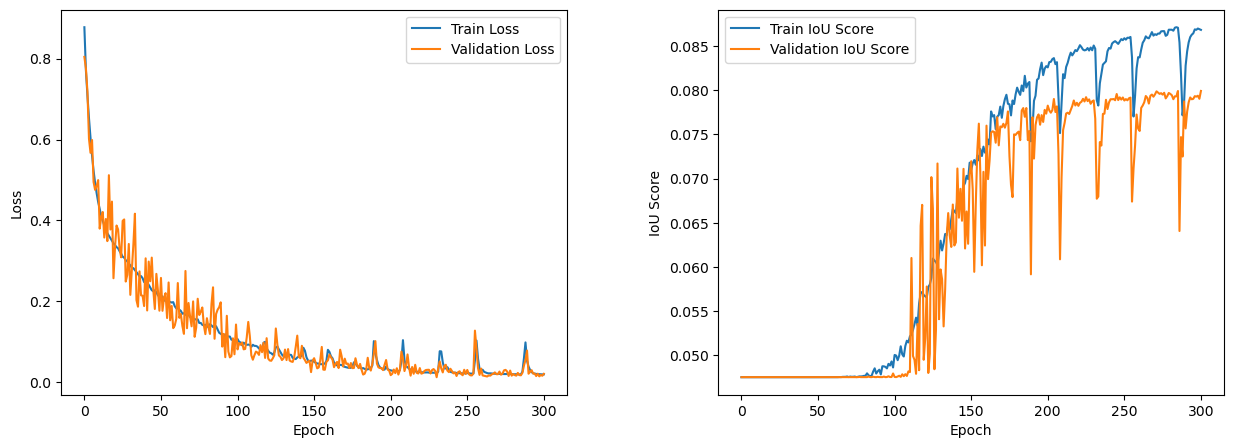

Figure: Cached plots of the training run loss and IoU values

Loss values obtained during training of the model decrease over 300 epochs from values around 0.9 to values around 0.004. This is mainly due to the model being progressively better at "not responding" (since the majority of the target's pixels are 0) and differenciating the background from other foreground elements, which is the class that most positive (value of 1) pixels contains (see figures below for an example). 

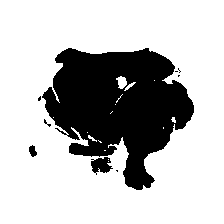 
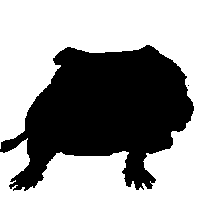

Figure: Prediction (top), ground truth (bottom) after 170 epochs. Class: background.

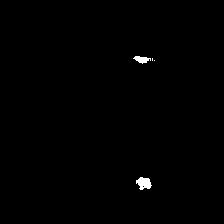 
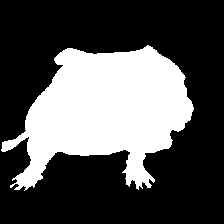

Figure: Prediction (top), ground truth (bottom) after 170 epochs. Class: Frog.

As for IoU, around 80 epochs in the training we can observe an increase of training IoU while Validation IoU starts fluctuating at 110 epochs. However, validation IoU imrpoves more slowly after 170 epochs, denoting the point where training the model further would not yield better results. Therefore we conclude that for this run, the model reached its peak performance after 170-175 epochs.

Performance-wise, the model showed poor results (as depicted by the low IoU value). This could be due to a number of reasons that we enumerate in the following bullet point:
- Large Learning rate: training stagnation could be solved by tranining in phases with progressively smaller tranining rate to avoid overshooting better results.
- Insufficient weight to positive values.
- Small image database for training. 
- Need for splitting the Encoder and Decoder. Training them separately can improve performance.

In [ ]:
# Code to use the pre-trained model

# Create instances of ImageDataset for test dataset
test_dataset = ImageDataset(test_df['img'].to_list(), test_df['seg'].to_numpy(), transform=None, target_transform=None)
Nimages = test_dataset.__len__()
print("Number of images is ", Nimages)

# Initialize model with the best available weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval() # set the model to evaluation to avoid saving gradients
model.to(DEVICE)

# Initialize the inference transforms (resize + transforms such as normalization)
preprocess = weights.transforms().to(DEVICE)

The following code uses Resnet50 to classify the images of the test dataframe and adds the results to their corresponding column (warning: takes long)

In [ ]:
# for pn in range(Nimages): #Nimages

#     im = test_dataset.__getitem__(pn)[0]
#     im = np.expand_dims(im,axis=0)
#     im = np.swapaxes(im,1,3)
#     im = np.swapaxes(im,2,3)
#     im = torch.tensor(im).to(DEVICE)
    
#     with torch.no_grad():
#         # Apply inference preprocessing transforms
#         im = preprocess(im)
#         # Use the model
#         prediction = model(im)["out"]
#         normalized_masks = prediction.softmax(dim=1)
#         for c in range(20):
#             test_df["seg"][c] = normalized_masks[:,c,:,:].cpu().numpy()

#     print("Image #", pn)

#     # See the result only every 100 images
#     if pn % 100 == 0:
#         class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
#         fig, axs = plt.subplots(1, 21, figsize=(5 * 20, 5 * 2))
#         for cla in class_to_idx:
#             mask = normalized_masks[0, class_to_idx[cla]]
#             axs[class_to_idx[cla]].imshow(mask.to('cpu').detach().numpy())
#             axs[class_to_idx[cla]].set_title(cla,fontsize=14)
        

In [ ]:
# check the head of test_df to see if it correctly set the values

# test_df.head(10)


## Submit to competition


In [ ]:
# generate_submission(test_df)

# 4 Adversarial attack NNs

## 4.1. Loading and preprocessing the data

In [ ]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from sklearn.metrics import f1_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import numpy as np
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision import transforms as tt
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from torchvision import models
from tqdm.notebook import tqdm


# Check if CUDA is available and use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

- Read the train dataset CSV file into a pandas DataFrame.
- Extract the labels and image paths from the DataFrame.
- Define the `ImageDataset` class for custom dataset handling.
- Define the data transformations using torchvision transforms.
- Create an instance of the `ImageDataset` for the train dataset.

In [ ]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))


# ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).cpu()  # Ensure image is a Tensor and is on the CPU
        
        if self.labels is not None:
            label = self.labels[idx]
            # Convert label to binary format
            label_binary = torch.tensor(label, dtype=torch.float32)
            return image, label_binary
        else:
            return image

In [ ]:
# Calculate mean and std
train_dataset_for_stats = ImageDataset(train_df['img'].to_list(), train_df[labels].to_numpy(), transform=ToTensor())
meanRGB = [np.mean(x[0].numpy(), axis=(1, 2)) for x in train_dataset_for_stats]
stdRGB = [np.std(x[0].numpy(), axis=(1, 2)) for x in train_dataset_for_stats]


meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))

# Data transforms
train_tfms = tt.Compose([
    tt.Resize((300, 300)),
    tt.RandomChoice([
        tt.ColorJitter(brightness=(0.80, 1.20)),
        tt.RandomGrayscale(p=0.25)
    ]),
    tt.RandomHorizontalFlip(p=0.25),
    tt.RandomRotation(25),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(330),
    tt.CenterCrop(300),
    tt.ToTensor(),
    tt.Normalize(*stats)
])


# Split the data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create instances of ImageDataset for the train and validation datasets
train_dataset = ImageDataset(train_df['img'].to_list(), train_df[labels].to_numpy(), transform=train_tfms)
val_dataset = ImageDataset(val_df['img'].to_list(), val_df[labels].to_numpy(), transform=valid_tfms)

# Create DataLoaders for train_dataset and val_dataset
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
import torch

# Calculate the number of labels for each class by summing the values in each column
class_counts = train_df[labels].sum(axis=0)

def calculate_weights(class_counts):
    total_samples = class_counts.sum()
    neg_counts = total_samples - class_counts
    weights = neg_counts / (class_counts + 1e-5)

    return torch.as_tensor(weights, dtype=torch.float)

weights_tensor = calculate_weights(class_counts)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_tensor = weights_tensor.to(device)

print(weights_tensor)


In [ ]:
def get_available_device():
    """Returns the default device (GPU if available, else CPU)"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to the specified device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DataLoaderDevice():
    """Wrapper class for a dataloader that moves data to a specified device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to the device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Returns the number of batches"""
        return len(self.dl)


In [ ]:
device = get_available_device()
device

In [ ]:
train_dl = DataLoaderDevice(train_dl, device)
val_dl = DataLoaderDevice(val_dl, device)

In [ ]:
class ClassificationModelBase(nn.Module):
    def forward_training(self, batch):
        images, labels = batch 
        out = self(images)  # Generate predictions
        loss = F.binary_cross_entropy_with_logits(out, labels, pos_weight=weights_tensor, reduction='sum')                 
        return loss

    def forward_validation(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.binary_cross_entropy_with_logits(out, labels, pos_weight=weights_tensor, reduction='sum')
        
        # Convert the output to binary format
        predicted_labels = torch.sigmoid(out) > 0.5

        # Calculate accuracy and F1 score
        accuracy = accuracy_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
        f1 = f1_score(labels.cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
        
        # average precision
        ap = average_precision_score(labels.cpu().detach().numpy().reshape(-1), out.cpu().detach().numpy().reshape(-1))
        return {'val_loss': loss.detach(), 'val_accuracy': accuracy, 'val_f1': f1, 'val_ap': ap}


    def epoch_validation_summary(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_aps = [x['val_ap'] for x in outputs]
        epoch_ap = (np.array(batch_aps)).mean()      # Combine average precision scores
        batch_accs = [x['val_accuracy'] for x in outputs]
        epoch_acc = np.array(batch_accs).mean()  # Calculate mean accuracy
        batch_f1s = [x['val_f1'] for x in outputs]
        epoch_f1 = np.array(batch_f1s).mean()  # Calculate mean F1 score

        return {'val_loss': epoch_loss.item(), 'val_ap': epoch_ap, 'val_accuracy': epoch_acc, 'val_f1': epoch_f1}



    def print_epoch_summary(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_ap: {:.4f}, val_accuracy: {:.4f}, val_f1: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_ap'], result['val_accuracy'], result['val_f1']))
            
  


In [ ]:
epochs=[]

class CustomScheduler:
    def __init__(self, optimizer, base_lr=0.00015, max_lr=0.00017, epochs=epochs, steps_per_epoch=len(train_dl)):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.total_steps = epochs * steps_per_epoch
        self.step_count = 0  # renamed from 'step' to 'step_count'

    def step(self):
        self.step_count += 1  # updated here as well
        lr = self.calculate_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def calculate_lr(self):
        return self.base_lr + ((self.max_lr - self.base_lr) / self.total_steps) * self.step_count  # updated here as well


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.forward_validation(batch) for batch in val_loader]
    return model.epoch_validation_summary(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    training_results = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.forward_training(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.print_epoch_summary(epoch, result)
        training_results.append(result)
    return training_results

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    training_results = []
    best_loss = float('inf')  # initialize with high value

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    
    # Set up custom learning rate scheduler
    sched = CustomScheduler(optimizer, epochs=epochs, steps_per_epoch=len(train_loader))
    
    best_ap = 0  # Initialize best_ap with a low value

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        train_f1s = []
        lrs = []

        for batch in tqdm(train_loader):
            loss = model.forward_training(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

            # Calculate accuracy and F1 score on training data
            predicted_labels = torch.sigmoid(model(batch[0].to(device))) > 0.5
            train_accuracy = accuracy_score(batch[1].cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
            train_f1 = f1_score(batch[1].cpu().detach().numpy().reshape(-1), predicted_labels.cpu().detach().numpy().reshape(-1))
            train_accs.append(train_accuracy)
            train_f1s.append(train_f1)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        result['train_accuracy'] = np.mean(train_accs)
        result['train_f1'] = np.mean(train_f1s)

        # Save the best model
        if result['val_ap'] > best_ap:
            best_ap = result['val_ap']
            torch.save(model.state_dict(), 'best_model.pth')  # save the best model to a file

        model.print_epoch_summary(epoch, result)
        training_results.append(result)

    
    return training_results



    

In [ ]:
class PascalVocModelKUL(ClassificationModelBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        num_classes=20
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Get the object categories from the label columns
def get_categories(df):
    return list(df.columns)

object_categories = get_categories(train_df)

In [ ]:
model = PascalVocModelKUL(len(object_categories))
to_device(model, device);

In [ ]:
epochs = 7
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
def plot_losses(training_results, ax):
    losses = [x['val_loss'] for x in training_results]
    ax.plot(losses, '-x')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs. No. of epochs')

def plot_avg_precision_scores(training_results, ax):
    apscores = [x['val_ap'] for x in training_results]
    ax.plot(apscores, '-x')
    ax.set_xlabel('epoch')
    ax.set_ylabel('avg_precision_score')
    ax.set_title('avg_precision_score vs. No. of epochs')
    
def plot_accuracy(training_results, ax):
    accuracies = [x.get('val_accuracy') for x in training_results]
    ax.plot(accuracies, '-x')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title('Accuracy vs. No. of epochs')

def plot_f1(training_results, ax):
    f1_scores = [x.get('val_f1') for x in training_results]
    ax.plot(f1_scores, '-x')
    ax.set_xlabel('epoch')
    ax.set_ylabel('F1 score')
    ax.set_title('F1 Score vs. No. of epochs')

In [ ]:
training_results = []

In [ ]:
# Training the model
training_results = [evaluate(model, val_dl)]

training_results += fit_one_cycle(epochs, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# now call the modified functions and pass the corresponding axes
plot_losses(training_results, ax=axs[0, 0])
plot_avg_precision_scores(training_results, ax=axs[0, 1])
plot_accuracy(training_results, ax=axs[1, 0])
plot_f1(training_results, ax=axs[1, 1])

# Automatically adjust the subplot parameters to give specified padding
plt.tight_layout()
plt.show()

In [ ]:
object_categories = get_categories(train_df)
print(object_categories)

In [ ]:
def predict_and_plot_sample(sample_index, dataset, model):
    plt.figure()  # Create a new figure
    img, label = dataset[sample_index]
    plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
    label_text = get_label_txt(label)
    xb = to_device(img.unsqueeze(0), device)
    preds = model(xb)
    output = (torch.sigmoid(preds.cpu().detach()))>0.5
    result = []
    idx_lst = output.tolist()[0]
    for i in range(20):
        if idx_lst[i]==1:
            result.append(object_categories[i])
    print('Label:', label_text, ', Predicted:', result)

# Gather training_results
training_results = [evaluate(model, val_dl)]

In [ ]:
# Define the best_model_path variable and assign it the path of the best model file
best_model_path = '/kaggle/working/best_model.pth'

# Load best model
model.load_state_dict(torch.load(best_model_path))

In [ ]:
val_loss = training_results[0]['val_loss']
val_ap = training_results[0]['val_ap']
val_acc = training_results[0]['val_accuracy']
val_f1 = training_results[0]['val_f1']
print(f"Loss: {val_loss:.4f}, Avg Precision Score: {val_ap:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def get_label_txt(label):
    # Assuming object_categories is defined globally
    return [object_categories[i] for i, val in enumerate(label) if val == 1]

def plot_sample_predictions(sample_indices, dataset, df, model):
    num_samples = len(sample_indices)
    num_cols = 3  # Number of columns in the grid
    num_rows = math.ceil(num_samples / num_cols)  # Number of rows in the grid

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    fig.tight_layout()

    for i, sample_index in enumerate(sample_indices):
        row = i // num_cols
        col = i % num_cols

        img, label = dataset[sample_index]
        label_text = get_label_txt(label)
        xb = to_device(img.unsqueeze(0), device)
        preds = model(xb)
        output = (torch.sigmoid(preds.cpu().detach())) > 0.5
        result = [object_categories[j] for j in range(20) if output[0, j] == 1]

        # Denormalize image
        denorm_img = denormalize(img.unsqueeze(0), *stats).squeeze().permute(1, 2, 0).clamp(0, 1)

        # Show original image from dataframe
        orig_img = df['img'].iloc[sample_index]
        
        axs[row, col].imshow(orig_img)
        axs[row, col].set_title(f"Label: {label_text}\nPredicted: {result}")
        axs[row, col].axis("off")

    plt.show()

# Sample predictions
sample_indices = [100, 50, 85, 30, 10, 35, 44, 56, 99, 120, 34, 89]
plot_sample_predictions(sample_indices, val_dataset, val_df, model)  # added `val_df` as the third argument



## 4.2. Adversarial Attack

We consider a white-box adversarial attack where the objective is to manipulate a convolutional autoencoder to generate noise from an image in a manner that confuses the targeted model. We choose to target the pretrained model for the classification part of the assignment (Resnet34 pretrained on ImageNet), because it seems to be the best performing model across all assignment tasks. 

In order to regulate the magnitude of perturbations, two approaches can be employed. The first approach involves applying a squashing function, such as a sigmoid or hyperbolic tangent, scaled by a constant. The second approach involves incorporating regularization techniques, such as l2-regularization norm, to constrain the weights of the model. It is worth noting that stronger perturbations increase the likelihood of inducing misclassification, but they also become more noticeable to human observers.

A challenge arises due to the limited availability of labeled data for training an adversarial attack, as the model under attack is trained using only 80% of the original training set. A straightforward solution to this problem would be to utilize the complete Voc2009 dataset, which can be accessed at http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html#data, instead of relying solely on the subset from the Kaggle competition. However, this approach does not seem to be in the spirit of the assignment. Consequently, we opt to employ the unlabeled test set provided on Kaggle for training the adversarial attack. We justify this decision since the training data for adversarial attacks consists of fake labels, and having groundtruth isn't necessary. However, this approach introduces limitations in terms of the quality and informativeness of the fake labels.

To explore different variations of fake labels, we experimented with the following approaches:
1. Assigning a label of 0 to every class. Ideally, this would result in the targeted model not recognizing any objects on the image
2. Assigning a label of 0.5 to every class, with an idea that model outputs will be no better than a random guess.
3. Assigning a label of 1 to every class, making the model think every class of object is on each image.

Various other hyperparameters have been experimented with:
- different autoencoder architectures (with changes in number of layers, convolution kernel sizes, activation functions (LeakyRelu, Relu, Sigmoid), autoencoders with and without a fully connected layer in the middle.
- optimizers: Adam, Adagrad, SGD
- restricting the scale of the perturbations with l2 regularization and/or hyperbolic tangent at the autoencoder output

Most successful attacks (measured by a decrease in f1-score) were observed while using labels zero for each class, although even these are not particularly successful. 

It seems that proposed autoencoder architectures do not have the capacity to fool the targeted model when the scale of perturbations is very small (not noticable by human). A likely reason for this is the Resnet34's size and pretraining procedure; having many more parameters and being pretrained on large amounts of data, make it's latent representations robust against targeted attacks from small capacity models. 

Nevertheless, even if the target models weren't completely fooled, a clear decrease in confidence is observed. This makes our attack successful for use cases where low confidence predictions require human intervention.

Using a more sophisticated autoencoder model, training on more data and data with informed fake labels (e.g. inverting groundtruth) should result in a more successful attack. Additionally, our attack focused on all classes, a less ambitious approach, such as focusing on one label only (e.g. 'person') would probably yield better results considering small capacity models were used.

Regarding other, future improvements and potential directions for the assignment, during our exploration of perturbation strength manipulation, an intriguing idea for an adversarial attack emerged: generating strong perturbations that completely mask the original image while ensuring that the perturbed image is classified by the model in the same manner as the unperturbed image. This technique could be beneficial in scenarios where it is desirable to utilize a service, such as a classifier, while safeguarding the privacy of the classified data.

In [ ]:
from sklearn.metrics import classification_report

class VocAdversarial3(nn.Module):
    def __init__(self, model, scaling_factor=0.33):
        super(VocAdversarial3, self).__init__()
        
        self.scaling_factor=scaling_factor
        self.mp = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 64, 3, 1, bias=True)
        self.relu = nn.LeakyReLU(True)
        self.conv2 = nn.Conv2d(64, 32, 5, 1, bias=True)
        self.conv3 = nn.Conv2d(32, 16, 10, 1, bias=True)

        self.fc1 = nn.Linear(16*26*26, 200)
        self.fc2 = nn.Linear(200, 16*26*26)
        self.transConv1 = nn.ConvTranspose2d(16, 32, 10, 1, bias=True)
        self.transConv2 = nn.ConvTranspose2d(32, 64, 5, 1, bias=True)
        self.transConv3 = nn.ConvTranspose2d(64, 3, 3, 1, bias=True)
        self.upsample = nn.Upsample(scale_factor=2)
        self.model = model              #model under attack (e.g. MNIST classifier)
        model.requires_grad_(False)     #freezes gradients of the model under attack

    def forward(self, X):
        delta = self.mp(X) #150
        delta = self.conv1(delta) #148               
        delta = self.relu(delta)
        delta = self.mp(delta) #74
        delta = self.conv2(delta) #70           
        delta = self.relu(delta)
        delta = self.mp(delta) #35
        delta = self.conv3(delta) #31          
        delta = self.relu(delta)
        delta = self.fc1(torch.flatten(delta, 1, -1))
        delta = self.relu(delta)
        delta = self.fc2(delta)
        delta = self.relu(delta)
        delta = torch.reshape(delta, (1, 16, 26, 26))

        delta = self.transConv1(delta) #35
        delta = self.relu(delta)
        delta = self.upsample(delta)   #70
        delta = self.transConv2(delta) #74
        delta = self.relu(delta)
        delta = self.upsample(delta)   #148
        delta = self.transConv3(delta) #150
        delta = self.upsample(delta)   #300
        X_delta = X + torch.tanh(delta) * self.scaling_factor       #combines noise and original image
        self.delta = torch.tanh(delta) * self.scaling_factor
        self.X = X

        prediction = self.model.forward(X_delta)    #model under attack classifies perturbed image
        return prediction

In [ ]:
def plot_images(image, delta):
    plt.subplot(1, 3, 1)
    plt.gca().set_title('original image')

    im = torch.permute(image.detach().squeeze(), (2, 1, 0)).to(device='cpu')

    plt.imshow(im * std_tensor + mean_tensor)
    plt.subplot(1, 3, 2)
    plt.gca().set_title('delta')
    delta = torch.permute(delta.detach().squeeze(), (2, 1, 0)).to(device='cpu')
    plt.imshow(delta * std_tensor + mean_tensor)
    plt.subplot(1, 3, 3)
    plt.gca().set_title('original+delta')
    X_delta = (im + delta) * std_tensor + mean_tensor
    plt.imshow(X_delta)
    plt.show()

In [ ]:
torch.set_printoptions(precision=2)
np.set_printoptions(precision=2)

In [ ]:
mean_tensor = torch.tensor((meanR, meanG, meanB))
std_tensor = torch.tensor((stdR, stdG, stdB))

train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_dataset = ImageDataset(train_df['img'].to_list(), train_df[labels].to_numpy(), transform=valid_tfms)

In [ ]:
def train_adversarial(loss_fn, optimizer, trained_model, adversarial, train_dataloader, validation_dataloader, epochs=2, fake_labels=0.0):
    
    fake_labels = torch.full([1,20], fake_labels).to(device="cuda")
    
    for epoch in range(epochs):
        running_loss = 0.
        last_loss = 0.
        
        adversarial.train()
        trained_model.eval()
        for i, data in enumerate(train_dataloader):
                
            inputs, labels = data
            labels = fake_labels
            
            optimizer.zero_grad()
            outputs = adversarial(inputs.to(device='cuda'))

            loss = loss_fn(torch.sigmoid(outputs), labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

        groundtruth = []
        adversary_predicted = []
        predicted = []
        adversarial.eval()

        for i, data in enumerate(validation_dataloader):
            inputs, labels = data
            groundtruth.append((labels.to(device='cpu')))

            outputs = adversarial(inputs.to(device="cuda"))
            adversary_predicted.append((torch.sigmoid(outputs) > 0.5).long().to(device='cpu'))

            outputs = trained_model(inputs.to(device="cuda"))
            predicted.append((torch.sigmoid(outputs) > 0.5).long().to(device='cpu'))

        groundtruth = torch.cat(groundtruth, dim=1).squeeze()
        adversary_predicted = torch.cat(adversary_predicted, dim=1).squeeze()
        predicted = torch.cat(predicted, dim=1).squeeze()
        
        if epoch == 0:
            print('Classificiation report for original model without perturbations')
            print(f1_score(groundtruth, predicted))

        print('classification reports for adversarial model after epoch ', epoch)
        print('adversary----------------------')
        print(f1_score(groundtruth, adversary_predicted))



### 4.2.1 Fake labels 1

In [ ]:
tr_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

#model under attack
trained_model = model
model.eval()

#loading adversarial model
adversarial = VocAdversarial3(trained_model, scaling_factor=0.66)
adversarial.cuda()

optimizer = torch.optim.Adagrad(adversarial.parameters())
loss_fn = torch.nn.BCELoss()

train_adversarial(loss_fn=loss_fn, 
                  optimizer=optimizer,
                 trained_model=model,
                 adversarial=adversarial,
                 train_dataloader=tr_dl,
                 validation_dataloader=val_dl,
                 fake_labels=1.0)

In [ ]:
plot_images(adversarial.X, adversarial.delta)
print('logits without perturbations')
print(trained_model(adversarial.X))
print('logits with perturbations')
print(adversarial(adversarial.X))

### 4.2.2 Fake labels 0.5

In [ ]:
tr_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

#model under attack
trained_model = model
model.eval()

#loading adversarial model
adversarial = VocAdversarial3(trained_model, scaling_factor=0.66)
adversarial.cuda()

optimizer = torch.optim.Adagrad(adversarial.parameters())
loss_fn = torch.nn.BCELoss()

train_adversarial(loss_fn=loss_fn, 
                  optimizer=optimizer,
                 trained_model=model,
                 adversarial=adversarial,
                 train_dataloader=tr_dl,
                 validation_dataloader=val_dl,
                 fake_labels=0.5)

In [ ]:
plot_images(adversarial.X, adversarial.delta)
print('logits without perturbations')
print(trained_model(adversarial.X))
print('logits with perturbations')
print(adversarial(adversarial.X))

### 4.2.3 Fake labels 0

In [ ]:
#trainset_1 = torch.utils.data.Subset(train_dataset, [1, 2, 3, 4, 5])
#trainset_1 = val_dataset

tr_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

#model under attack
trained_model = model
model.eval()

#loading adversarial model
adversarial = VocAdversarial3(trained_model, scaling_factor=0.66)
adversarial.cuda()

optimizer = torch.optim.Adagrad(adversarial.parameters())
loss_fn = torch.nn.BCELoss()

train_adversarial(loss_fn=loss_fn, 
                  optimizer=optimizer,
                 trained_model=model,
                 adversarial=adversarial,
                 train_dataloader=tr_dl,
                 validation_dataloader=val_dl,
                 fake_labels=0.0)

In [ ]:
plot_images(adversarial.X, adversarial.delta)
print('logits without perturbations')
print(trained_model(adversarial.X))
print('logits with perturbations')
print(adversarial(adversarial.X))

### 4.2.4 Experiment with perturbations small in scale

In [ ]:
tr_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

#model under attack
trained_model = model
model.eval()

#loading adversarial model
adversarial = VocAdversarial3(trained_model, scaling_factor=0.1)
adversarial.cuda()

optimizer = torch.optim.Adagrad(adversarial.parameters())
loss_fn = torch.nn.BCELoss()

train_adversarial(loss_fn=loss_fn, 
                  optimizer=optimizer,
                 trained_model=model,
                 adversarial=adversarial,
                 train_dataloader=tr_dl,
                 validation_dataloader=val_dl,
                 fake_labels=0.0)

In [ ]:
plot_images(adversarial.X, adversarial.delta)
print('logits without perturbations')
print(trained_model(adversarial.X))
print('logits with perturbations')
print(adversarial(adversarial.X))

### 4.2.5 Misc. results

Before a model was trained on the VOC dataset, a simple testing environment was made to experiment with models trained on the MNIST dataset. The target model was sucessfully attacked despite having, 99.4% accuracy on MNIST

An example of an image originally classified as 3, after added perturbations classified as 9. The perturbation visualized in the middle is scaled by the plotting function, otherwise it would not be visible (as shown on the perturbed image on the right)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# img = mpimg.imread('/kaggle/input/mnist-result/Figure_3.png')
# imgplot = plt.imshow(img)
# plt.show()

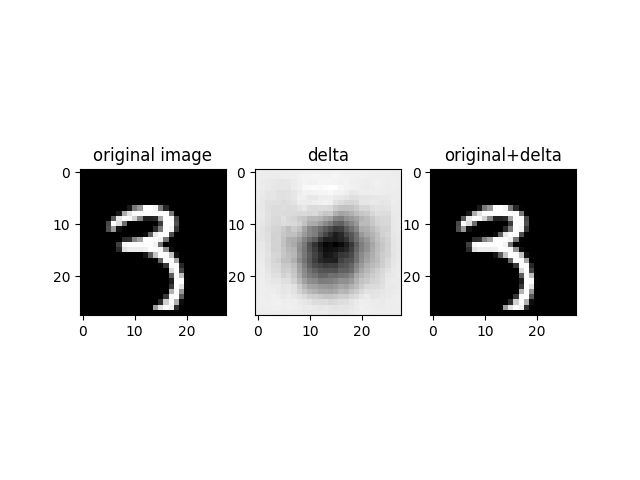

In [ ]:
from torch import nn
class MnistAdversarial(nn.Module):
    def __init__(self, model):
        super(MnistAdversarial, self).__init__()
        # Downsizing
        # input Bx28x28x3, output Bx25x25x16
        self.conv1 = nn.Conv2d(1, 16, 4, 1, 0, bias=False)
        print(self.conv1)
        self.relu1 = nn.ReLU(True)
        # Bx18x18x32
        self.conv2 = nn.Conv2d(16, 32, 8, 1, bias=False)
        self.relu2 = nn.ReLU(True)
        # Bx11x11x32
        self.conv3 = nn.Conv2d(32, 32, 8, 1, bias=False)
        self.relu3 = nn.ReLU(True)
        # resizing
        # Bx20x20x16
        self.transConv1 = nn.ConvTranspose2d(32, 16, 10, 1, bias=False)
        self.relu4 = nn.ReLU(True)
        # Bx28x28x3
        self.transConv2 = nn.ConvTranspose2d(16, 1, 9, 1, bias=False)

        self.model = model              #model under attack (e.g. MNIST classifier)
        model.requires_grad_(False)     #freezes gradients of the model under attack

    def forward(self, X):
        delta = self.conv1(X)               #Bx25x25x16
        delta = self.relu1(delta)
        delta = self.conv2(delta)           #Bx18x18x32
        delta = self.relu2(delta)
        delta = self.conv3(delta)           #Bx11x11x32
        delta = self.relu3(delta)
        delta = self.transConv1(delta)      #Bx20x20x16
        delta = self.relu4(delta)
        delta = self.transConv2(delta)      #Bx28x28x3

        X_delta = X + delta                 #combines noise and original image

        self.delta = delta
        self.X = X

        prediction = self.model.forward(X_delta)    #model under attack classifies perturbed image
        return prediction


In [ ]:
from torch import nn
import torch.nn.functional as F


class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy
# import torch
# import torchvision.datasets

# from models.mnist_attacker import MnistAdversarial
# from models.mnist_model import MnistModel

# torch.set_printoptions(precision=2)
# numpy.set_printoptions(precision=2)

# #loading model under attack
# trained_model = MnistModel()
# trained_model.load_state_dict(torch.load('/kaggle/input/mnist-model/model.pth'))

# #loading adversarial model
# adversarial = MnistAdversarial(trained_model)

# '''
# load dataset (this dataset still has original, correct labels (labels are changed in the train loop for now, 
# this should be changed (e.g. by creating a custom dataset)
# '''
# dataset = torchvision.datasets.MNIST('dataset/', train=False, download=True,
#                                transform=torchvision.transforms.Compose([
#                                    torchvision.transforms.ToTensor(),
#                                    torchvision.transforms.Normalize(
#                                        (0.1307,), (0.3081,))
#                                    ]))

# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# '''
# SGD optimizer
# weight_decay is the L2 regularization factor 
# (the stronger the regularization factor, the less the images will be perturbed (i think))
# '''

# optimizer = torch.optim.SGD(adversarial.parameters(), lr=0.001, momentum=0.9, weight_decay=1)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# epochs = 5
# for epoch in range(epochs):
#     running_loss = 0.
#     last_loss = 0.
#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(data_loader):
#         # Every data instance is an input + label pair
#         inputs, labels = data
#         labels = torch.full([1, 10], 1/10)
#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = adversarial(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         if i % 1000 == 0:
#             with torch.no_grad():
#                 original_outputs = trained_model(inputs)
#                 original_probabilities = torch.exp(original_outputs)
#                 original_classification = torch.argmax(original_probabilities)

#                 print('original')
#                 print(original_outputs.numpy())
#                 print(original_probabilities.numpy())
#                 print(original_classification.numpy())

#                 probabilities = torch.exp(outputs)
#                 classification = torch.argmax(probabilities)
#                 print('adversary')
#                 print(outputs.numpy())
#                 print(probabilities.numpy())
#                 print(classification.numpy())
#                 '''
#                 print('Original image probabilities')
#                 print(probabilities.numpy())
#                 print('label predicted = ', classification.item())
#                 print('Perturbed image probabilities')
#                 print(torch.exp(outputs).detach().numpy())
#                 print('label predicted =', torch.argmax(torch.exp(outputs)).item())
#                 '''
#                 plt.subplot(1, 3, 1)
#                 plt.gca().set_title('original image')
#                 plt.imshow(adversarial.X.detach().squeeze(), cmap='gray')
#                 plt.subplot(1, 3, 2)
#                 plt.gca().set_title('delta')
#                 plt.imshow(adversarial.delta.detach().squeeze(), cmap='gray')
#                 plt.subplot(1, 3, 3)
#                 plt.gca().set_title('original+delta')
#                 X_delta = adversarial.X.detach().squeeze() + adversarial.delta.detach().squeeze()
#                 plt.imshow(X_delta, cmap='gray')
#                 plt.show()
#                 last_loss = running_loss / 1000  # loss per batch
#                 print('  batch {} loss: {}'.format(i + 1, last_loss))
#                 tb_x = epochs * len(data_loader) + i + 1

Below are two convolutional autoencoders used for adversarial attacks on the VOC dataset. They performed poorly, giving the same output regardless of the input. Primary suspected cause are convolution kernels being too large.

In [ ]:
import torch
from torch import nn
class VocAdversarial(nn.Module):
    def __init__(self, model):
        super(VocAdversarial, self).__init__()
        # Downsizing
        # input Bx3x300x300, output Bx16x281x281
        self.conv1 = nn.Conv2d(3, 16, 20, 1, 0, bias=False)
        self.relu = nn.ReLU(True)
        # Bx32x262x262
        self.conv2 = nn.Conv2d(16, 32, 20, 1, bias=False)
        # Bx32x243x243
        self.conv3 = nn.Conv2d(32, 32, 40, 1, bias=False)
        # Bx32x224x224
        self.conv4 = nn.Conv2d(32, 32, 60, 1, bias=False)
        # Bx32x205x205
        self.conv5 = nn.Conv2d(32, 32, 80, 1, bias=False)
        # Bx32x186x186
        self.conv6 = nn.Conv2d(32, 32, 20, 1, bias=False)
        # Bx32x167x167
        self.conv7 = nn.Conv2d(32, 32, 20, 1, bias=False)
        # Bx32x148x148
        self.conv8 = nn.Conv2d(32, 32, 20, 1, bias=False)

        self.fc1 = nn.Linear(32*28*28, 50)
        # resizing
        self.fc2 = nn.Linear(50, 32*28*28)
        # Bx32x205x205
        self.transConv1 = nn.ConvTranspose2d(32, 32, 20, 1, bias=False)
        # Bx32x224x224
        self.transConv2 = nn.ConvTranspose2d(32, 32, 20, 1, bias=False)
        # Bx16x243x243
        self.transConv3 = nn.ConvTranspose2d(32, 32, 80, 1, bias=False)
        # Bx3x262x262
        self.transConv4 = nn.ConvTranspose2d(32, 32, 60, 1, bias=False)
        # Bx16x281x281
        self.transConv5 = nn.ConvTranspose2d(32, 32, 40, 1, bias=False)
        # Bx16x281x281
        self.transConv6 = nn.ConvTranspose2d(32, 32, 20, 1, bias=False)
        # Bx16x281x281
        self.transConv7 = nn.ConvTranspose2d(32, 16, 20, 1, bias=False)
        # Bx3x300x300
        self.transConv8 = nn.ConvTranspose2d(16, 3, 20, 1, bias=False)

        self.model = model              #model under attack (e.g. MNIST classifier)
        model.requires_grad_(False)     #freezes gradients of the model under attack

    def forward(self, X):
        delta = self.conv1(X)               #Bx25x25x16
        delta = self.relu(delta)
        delta = self.conv2(delta)           #Bx18x18x32
        delta = self.relu(delta)
        delta = self.conv3(delta)           #Bx11x11x32
        delta = self.relu(delta)
        delta = self.conv4(delta)           #Bx11x11x32
        delta = self.relu(delta)
        delta = self.conv5(delta)           #Bx11x11x32
        delta = self.relu(delta)
        delta = self.conv6(delta)           #Bx11x11x32
        delta = self.relu(delta)
        delta = self.conv7(delta)           #Bx11x11x32
        delta = self.relu(delta)
        delta = self.conv8(delta)           #Bx11x11x32
        delta = self.relu(delta)

#        delta = self.fc1(torch.flatten(delta, 1, -1))
 #       delta = self.relu(delta)
  #      delta = self.fc2(delta)
   #     delta = self.relu(delta)
    #    delta = torch.reshape(delta, (1, 32, 28, 28))

        delta = self.transConv1(delta)      #Bx20x20x16
        delta = self.relu(delta)
        delta = self.transConv2(delta)      #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv3(delta)       #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv4(delta)         #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv5(delta)         #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv6(delta)     #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv7(delta)     #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv8(delta)     #Bx28x28x3
        X_delta = X + torch.tanh(delta)          #combines noise and original image
        self.delta = torch.tanh(delta)
        self.X = X

        prediction = self.model.forward(X_delta)    #model under attack classifies perturbed image
        return prediction



class VocAdversarial2(nn.Module):
    def __init__(self, model):
        super(VocAdversarial2, self).__init__()

        self.mp = nn.MaxPool2d(3, 3)
        self.conv1 = nn.Conv2d(3, 16, 20, 1, 0, bias=False)
        self.relu = nn.LeakyReLU(True)
        self.conv2 = nn.Conv2d(16, 32, 20, 1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, 40, 1, bias=False)

        self.fc1 = nn.Linear(64*23*23, 50)
        # resizing
        self.fc2 = nn.Linear(50, 64*23*23)
        # Bx32x205x205
        self.transConv1 = nn.ConvTranspose2d(64, 32, 40, 1, bias=False)
        # Bx32x224x224
        self.transConv2 = nn.ConvTranspose2d(32, 16, 20, 1, bias=False)
        # Bx16x243x243
        self.transConv3 = nn.ConvTranspose2d(16, 3, 20, 1, bias=False)
        self.upsample = nn.Upsample(scale_factor=3)
        self.model = model              #model under attack (e.g. MNIST classifier)
        model.requires_grad_(False)     #freezes gradients of the model under attack

    def forward(self, X):
        delta = self.mp(X)
        delta = self.conv1(delta)               #Bx25x25x16
        delta = self.relu(delta)
        delta = self.conv2(delta)           #Bx18x18x32
        delta = self.relu(delta)
        delta = self.conv3(delta)           #Bx11x11x32
        delta = self.relu(delta)
        
     #   delta = self.fc1(torch.flatten(delta, 1, -1))
     #   delta = self.relu(delta)
     #   delta = self.fc2(delta)
     #   delta = self.relu(delta)
     #   delta = torch.reshape(delta, (1, 64, 23, 23))

        delta = self.transConv1(delta)      #Bx20x20x16
        delta = self.relu(delta)
        delta = self.transConv2(delta)      #Bx28x28x3
        delta = self.relu(delta)
        delta = self.transConv3(delta)       #Bx28x28x3
        delta = self.upsample(delta)
        X_delta = X + torch.tanh(delta)*20         #combines noise and original image
        self.delta = torch.tanh(delta)*20
        self.X = X

        prediction = self.model.forward(X_delta)    #model under attack classifies perturbed image
        return prediction

# 5. Discussion

 

## 5.1 Classification

 

In the classification part of the assignment, we chose to approach the issue at hand both from by training custom made neural networks to be trained from scratch, as well as implementing one based upon a pretrained version of ResNet50.

 

As stated in the corresponding section above, we implemented three different CNN-based neural network models to try and tackle the issue: SimpleNetwork (consisting of two stacks of a convolutional layer followed by a max pooling one), ComplexNetwork (four stacks of Convolutional + Max pooling layers followed by a fully connected one) and TinyVGG, which follows the architecture of VGG[5] using smaller dimension layers.

 

As expected, the model based on the pretrained ResNet50 outperformed every one of the trained-from-scratch models by a significant margin in every metric available. The main reason behind the difference in performance is the volume of training data provided: having available approximately 1/10th of the original dataset, while having the same amount of classes proved to be exceptionally challenging from the trained from scratch model in comparison to the pretrained one. Furthermore, there is the issue of resources: a restricted amount of time to complete the assignment, along with limited amount of hardware resources render the shallow model architectures incapable to outperform a model trained for amounts of time and on resources unavailable at a scale of a semester assignment.

 


## 5.2 Segmentation

 

Image segmentation involves identifying objects in an image and assigning each pixel to a recognized object or background. In recent years, fully convolutional neural networks utilizing the encoder-decoder architecture, such as Ronneberger et al.'s U-Net[4], have gained popularity for performing this task due to the advancements [1,2] in deep learning.

 

In order to tackle this problem, as seen in the corresponding previous section, we again decided to approach it with both an implementation from scratch and pretrained. For our trained-from-scratch model, we chose to implement a U-Net[4] architecture based one, whereas for the pretrained one we once again chose to base it off ResNet.

 

Yet again, in this case, the issues we faced on the classification task are still present: small, imbalanced training set and insufficient hardware resources to train deep architectures render the custom made U-Net model unable to converge and yield adequate results during inference. On the contrary, the pretrained ResNet provides very high quality results in terms of Intersection-over-Union, without much effort on fine-tuning and adjusting it to our data.

 


## 5.3 Adversary Attack

 

For the last part of the assignment, we investigated a white-box adversarial attack strategy in which the objective was to manipulate a convolutional autoencoder to generate noise from an image, thereby confusing the targeted model. The pretrained model chosen for this purpose was a variation of the classification component of the assignment, namely ResNet34 pretrained on ImageNet.

 

Two approaches were employed to regulate the magnitude of perturbations. The first approach involved the application of a squashing function, such as a sigmoid or hyperbolic tangent, scaled by a constant factor. The second approach incorporated regularization techniques, specifically the l2-regularization norm, to constrain the model's weights. It is noteworthy that stronger perturbations were found to increase the likelihood of inducing misclassification, albeit at the cost of becoming more noticeable to human observers.

 

In summary, the proposed autoencoder architectures proved inadequate in deceiving the targeted model with subtle perturbations that went unnoticed by humans. This was likely due to the robustness of ResNet34, which possesses a larger parameter count and has undergone extensive prior training. Consequently, its latent representations remained resilient against attacks from less powerful models. However, although the target models were not completely fooled, our attack did succeed in significantly reducing their confidence levels. As a result, our approach proves effective in scenarios where predictions with low confidence necessitate human intervention.

 

To enhance the attack's efficacy, future endeavors should involve employing more sophisticated autoencoder models trained on larger and more diverse datasets, including data with deliberately mislabeled information. By focusing on specific labels rather than targeting all classes, especially when utilizing smaller capacity models, better results can be achieved. Additionally, exploring the manipulation of perturbation strength has sparked an intriguing idea for an adversarial attack: generating strong perturbations that completely mask the original image while ensuring the perturbed image is classified in the same manner as the unaltered image. This technique holds potential for situations where leveraging services like classifiers is desired while safeguarding the privacy of the underlying data.

 

## 5.4 Theoretical vs. Real-World Scenarios

 

The first major outake one can have from this assignment is the importance of data when trying to implement a solution to tackle the problem of either image classification or segmentation. While theory (in means of recent academic research, publications, lectures, and even industry standards) imply that deep learning based solutions outperform every other method in terms of results, in cases such as ours that data are scarce, such techniques lead to failure. It is in these cases also that one could try to implement approaches based on more "classic" computer vision methods, such as e.g. feature extraction combined with a Machine Learning classifier, such as e.g. SVMs, to approach the tasks of classification.

 

Of course, there is no doubt that, provided enough data, deep learning based methods achieve exceptional results, not only in terms of accuracy in their estimations, but in terms of robustness and generalization on inconsistent image data.

 


## 5.5 References

 


- 1. https://doi.org/10.1016/j.asoc.2018.05.018
- 2. https://doi.org/10.1109/TPAMI.2021.3059968
- 3. https://arxiv.org/abs/1512.03385
- 4. https://arxiv.org/abs/1505.04597
- 5. https://doi.org/10.48550/arXiv.1409.1556